In [42]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torchsummary import summary
from transformers import ViTModel, ViTConfig, ViTForImageClassification

# set the path to the directory containing the npy files
data_dir = '/home/tejasri/Desktop/eurosat-ms/rgbnir-npy'

# set the path to save the trained model
model_path = '/home/tejasri/Desktop/eurosat-ms/'

# load the X and y data for each class
X = []
y = []
for i in range(10):
    X_i = np.load(f'{data_dir}/X{i}.npy')
    y_i = np.load(f'{data_dir}/y{i}.npy')
    X.append(X_i)
    y.append(y_i)

# concatenate the X and y data for all classes
X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)





In [43]:
import einops
print(X.shape)


X = einops.rearrange(X, 'b h w c -> b c h w')
              
print(X.shape)

print(X[0].shape)


(27000, 64, 64, 4)
(27000, 4, 64, 64)
(4, 64, 64)


In [44]:
from sklearn.model_selection import StratifiedShuffleSplit


# split the data into training and testing sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# split the data
for train_idx, test_idx in split.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

In [45]:
# define a custom dataset class for the EuroSAT multispectral data
class EuroSATDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# create data loaders for the training and testing sets
train_dataset = EuroSATDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = EuroSATDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# set the device to use for training and testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [46]:
print(len(train_loader))

675


In [47]:
print(len(test_loader))

169


In [48]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# Running resnet50 model

In [8]:
# Define the ResNet-50 model
model = models.resnet50(pretrained=False)
num_classes = 10
model.fc = nn.Linear(2048, num_classes)

# Modify the first convolution layer to accept 5-channel input
model.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move the model and loss function to the device
model.to(device)
criterion.to(device)

CrossEntropyLoss()

In [10]:
import torchsummary

# Print the model summary
torchsummary.summary(model.to(device), input_size=(4, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]          12,544
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]           4,096
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]          16,384
      BatchNorm2d-12          [-1, 256, 16, 16]             512
           Conv2d-13          [-1, 256, 16, 16]          16,384
      BatchNorm2d-14          [-1, 256,

In [11]:
train_losses = []
train_accu = []

def train(epoch):
    print('Epoch : %d'%epoch)
    
    model.train()
    running_loss=0
    correct=0
    total=0

    for images, labels in tqdm(train_loader):
        
        images = images.float().cuda()
        labels = labels.float().cuda()
        #print(images.size())
        #print(labels.size())
        # Forward pass
        #model = model.cuda()
        outputs = model(images)
        labels1= np.zeros((32,10))
        
        #labels1 = tensor.detach().cpu().numpy()
        for j in range(32):
            i=labels[j]
            i=int(i.item())
            # print(i)
            labels1[j][i]=1
        labels1=torch.from_numpy(labels1)
        #print(labels1.size())
        labels1=labels1.to(device='cuda')
        loss = criterion(outputs, labels1)
        
        
       # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        
    #Replaces pow(2.0) with abs() for L1 regularization
    
#     l2_lambda = 0.001
#     l2_norm = sum(p.pow(2.0).sum()
#                   for p in model.parameters())

#     loss = loss + l2_lambda * l2_norm
    
        
        running_loss += loss.item()
    
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
      
    train_loss=running_loss/len(train_loader)
    accu=100.*correct/total
  
    train_accu.append(accu)
    train_losses.append(train_loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))
    

In [12]:
eval_losses=[]
eval_accu=[]

def test(epoch):
    model.eval()

    running_loss=0
    correct=0
    total=0
    #print(test_loader)
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            
            #images = images.to(device='cuda', dtype=torch.float)
            images = images.float().cuda()
            labels = labels.float().cuda()
            #labels = labels.to(device='cuda', dtype=torch.float)
            
            # Predict classes using the model
            outputs = model(images)
            #print(labels.size())
            t,y=outputs.shape
            # print(t)
            labels1= np.zeros((t,10))
            for j in range(t):
                i=labels[j]
                i=int(i.item())
                labels1[j][i]=1
            labels1=torch.from_numpy(labels1)
            #print(labels1.size())
            labels1=labels1.to(device='cuda')
            #outputs=outputs.tensor()
            loss= criterion(outputs,labels1)
            running_loss+=loss.item()
            
            
           # Compute accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    test_loss=running_loss/len(test_loader)
    accu=100.*correct/total

    eval_losses.append(test_loss)
    eval_accu.append(accu)

    print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 
    

In [13]:
from tqdm import tqdm

In [14]:
import time
epochs = 30

# Start the timer

start_time = time.time()
for epoch in range(1,epochs+1): 
    train(epoch)
    test(epoch)
# End the timer
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time

print('Training time: {:.2f} seconds'.format(training_time))


Epoch : 1


100%|█████████████████████████████████████████| 675/675 [00:24<00:00, 27.76it/s]


Train Loss: 1.116 | Accuracy: 64.602


100%|█████████████████████████████████████████| 169/169 [00:01<00:00, 95.33it/s]


Test Loss: 0.912 | Accuracy: 68.333
Epoch : 2


100%|█████████████████████████████████████████| 675/675 [00:24<00:00, 27.96it/s]


Train Loss: 0.780 | Accuracy: 74.583


100%|█████████████████████████████████████████| 169/169 [00:01<00:00, 99.89it/s]


Test Loss: 1.133 | Accuracy: 75.315
Epoch : 3


100%|█████████████████████████████████████████| 675/675 [00:24<00:00, 27.94it/s]


Train Loss: 0.679 | Accuracy: 77.269


100%|█████████████████████████████████████████| 169/169 [00:01<00:00, 96.91it/s]


Test Loss: 0.834 | Accuracy: 76.185
Epoch : 4


100%|█████████████████████████████████████████| 675/675 [00:24<00:00, 27.84it/s]


Train Loss: 0.596 | Accuracy: 79.926


100%|█████████████████████████████████████████| 169/169 [00:01<00:00, 95.91it/s]


Test Loss: 0.980 | Accuracy: 69.611
Epoch : 5


100%|█████████████████████████████████████████| 675/675 [00:24<00:00, 27.90it/s]


Train Loss: 0.454 | Accuracy: 84.366


100%|█████████████████████████████████████████| 169/169 [00:01<00:00, 98.99it/s]


Test Loss: 0.654 | Accuracy: 76.796
Epoch : 6


100%|█████████████████████████████████████████| 675/675 [00:24<00:00, 27.77it/s]


Train Loss: 0.520 | Accuracy: 83.310


100%|█████████████████████████████████████████| 169/169 [00:01<00:00, 96.28it/s]


Test Loss: 0.630 | Accuracy: 82.074
Epoch : 7


100%|█████████████████████████████████████████| 675/675 [00:24<00:00, 27.84it/s]


Train Loss: 0.441 | Accuracy: 84.884


100%|█████████████████████████████████████████| 169/169 [00:01<00:00, 94.97it/s]


Test Loss: 1.046 | Accuracy: 71.537
Epoch : 8


100%|█████████████████████████████████████████| 675/675 [00:24<00:00, 27.78it/s]


Train Loss: 0.423 | Accuracy: 85.907


100%|█████████████████████████████████████████| 169/169 [00:01<00:00, 98.95it/s]


Test Loss: 0.639 | Accuracy: 78.019
Epoch : 9


100%|█████████████████████████████████████████| 675/675 [00:24<00:00, 27.89it/s]


Train Loss: 0.407 | Accuracy: 85.685


100%|█████████████████████████████████████████| 169/169 [00:01<00:00, 97.13it/s]


Test Loss: 0.730 | Accuracy: 76.222
Epoch : 10


100%|█████████████████████████████████████████| 675/675 [00:24<00:00, 27.78it/s]


Train Loss: 0.299 | Accuracy: 89.519


100%|█████████████████████████████████████████| 169/169 [00:01<00:00, 98.62it/s]


Test Loss: 0.236 | Accuracy: 92.019
Epoch : 11


100%|█████████████████████████████████████████| 675/675 [00:24<00:00, 27.77it/s]


Train Loss: 0.263 | Accuracy: 90.824


100%|█████████████████████████████████████████| 169/169 [00:01<00:00, 99.50it/s]


Test Loss: 0.365 | Accuracy: 87.907
Epoch : 12


100%|█████████████████████████████████████████| 675/675 [00:24<00:00, 27.88it/s]


Train Loss: 0.244 | Accuracy: 91.727


100%|█████████████████████████████████████████| 169/169 [00:01<00:00, 97.55it/s]


Test Loss: 0.280 | Accuracy: 90.556
Epoch : 13


100%|█████████████████████████████████████████| 675/675 [00:24<00:00, 27.92it/s]


Train Loss: 0.219 | Accuracy: 92.250


100%|█████████████████████████████████████████| 169/169 [00:01<00:00, 98.55it/s]


Test Loss: 0.224 | Accuracy: 92.130
Epoch : 14


100%|█████████████████████████████████████████| 675/675 [00:23<00:00, 28.28it/s]


Train Loss: 0.285 | Accuracy: 90.519


100%|█████████████████████████████████████████| 169/169 [00:01<00:00, 96.10it/s]


Test Loss: 0.619 | Accuracy: 79.148
Epoch : 15


100%|█████████████████████████████████████████| 675/675 [00:24<00:00, 28.05it/s]


Train Loss: 0.210 | Accuracy: 92.616


100%|█████████████████████████████████████████| 169/169 [00:01<00:00, 93.84it/s]


Test Loss: 0.318 | Accuracy: 89.204
Epoch : 16


100%|█████████████████████████████████████████| 675/675 [00:23<00:00, 28.19it/s]


Train Loss: 0.185 | Accuracy: 93.458


100%|████████████████████████████████████████| 169/169 [00:01<00:00, 102.19it/s]


Test Loss: 0.256 | Accuracy: 90.815
Epoch : 17


100%|█████████████████████████████████████████| 675/675 [00:23<00:00, 28.36it/s]


Train Loss: 0.157 | Accuracy: 94.435


100%|████████████████████████████████████████| 169/169 [00:01<00:00, 102.17it/s]


Test Loss: 0.332 | Accuracy: 88.963
Epoch : 18


100%|█████████████████████████████████████████| 675/675 [00:23<00:00, 28.43it/s]


Train Loss: 0.149 | Accuracy: 94.718


100%|████████████████████████████████████████| 169/169 [00:01<00:00, 101.55it/s]


Test Loss: 0.429 | Accuracy: 86.944
Epoch : 19


100%|█████████████████████████████████████████| 675/675 [00:23<00:00, 28.38it/s]


Train Loss: 0.137 | Accuracy: 95.208


100%|████████████████████████████████████████| 169/169 [00:01<00:00, 101.95it/s]


Test Loss: 0.577 | Accuracy: 84.278
Epoch : 20


100%|█████████████████████████████████████████| 675/675 [00:23<00:00, 28.36it/s]


Train Loss: 0.122 | Accuracy: 95.634


100%|████████████████████████████████████████| 169/169 [00:01<00:00, 102.23it/s]


Test Loss: 0.529 | Accuracy: 85.407
Epoch : 21


100%|█████████████████████████████████████████| 675/675 [00:23<00:00, 28.37it/s]


Train Loss: 0.161 | Accuracy: 94.898


100%|████████████████████████████████████████| 169/169 [00:01<00:00, 101.92it/s]


Test Loss: 0.522 | Accuracy: 85.593
Epoch : 22


100%|█████████████████████████████████████████| 675/675 [00:24<00:00, 27.98it/s]


Train Loss: 0.106 | Accuracy: 96.218


100%|█████████████████████████████████████████| 169/169 [00:01<00:00, 97.18it/s]


Test Loss: 0.348 | Accuracy: 89.870
Epoch : 23


100%|█████████████████████████████████████████| 675/675 [00:24<00:00, 28.05it/s]


Train Loss: 0.091 | Accuracy: 96.769


100%|█████████████████████████████████████████| 169/169 [00:01<00:00, 96.51it/s]


Test Loss: 0.290 | Accuracy: 91.278
Epoch : 24


100%|█████████████████████████████████████████| 675/675 [00:24<00:00, 27.80it/s]


Train Loss: 0.079 | Accuracy: 97.245


100%|████████████████████████████████████████| 169/169 [00:01<00:00, 101.61it/s]


Test Loss: 0.431 | Accuracy: 89.074
Epoch : 25


100%|█████████████████████████████████████████| 675/675 [00:23<00:00, 28.16it/s]


Train Loss: 0.082 | Accuracy: 97.125


100%|█████████████████████████████████████████| 169/169 [00:01<00:00, 95.59it/s]


Test Loss: 0.327 | Accuracy: 90.870
Epoch : 26


100%|█████████████████████████████████████████| 675/675 [00:23<00:00, 28.25it/s]


Train Loss: 0.079 | Accuracy: 97.444


100%|█████████████████████████████████████████| 169/169 [00:01<00:00, 95.43it/s]


Test Loss: 0.443 | Accuracy: 88.278
Epoch : 27


100%|█████████████████████████████████████████| 675/675 [00:24<00:00, 28.02it/s]


Train Loss: 0.081 | Accuracy: 97.176


100%|█████████████████████████████████████████| 169/169 [00:01<00:00, 99.64it/s]


Test Loss: 0.269 | Accuracy: 92.574
Epoch : 28


100%|█████████████████████████████████████████| 675/675 [00:23<00:00, 28.13it/s]


Train Loss: 0.062 | Accuracy: 97.949


100%|█████████████████████████████████████████| 169/169 [00:01<00:00, 97.80it/s]


Test Loss: 0.339 | Accuracy: 91.093
Epoch : 29


100%|█████████████████████████████████████████| 675/675 [00:23<00:00, 28.18it/s]


Train Loss: 0.062 | Accuracy: 97.722


100%|█████████████████████████████████████████| 169/169 [00:01<00:00, 95.81it/s]


Test Loss: 0.465 | Accuracy: 88.426
Epoch : 30


100%|█████████████████████████████████████████| 675/675 [00:24<00:00, 28.11it/s]


Train Loss: 0.061 | Accuracy: 97.903


100%|█████████████████████████████████████████| 169/169 [00:01<00:00, 96.86it/s]

Test Loss: 0.491 | Accuracy: 89.130
Training time: 774.03 seconds


In [15]:
import matplotlib.pyplot as plt


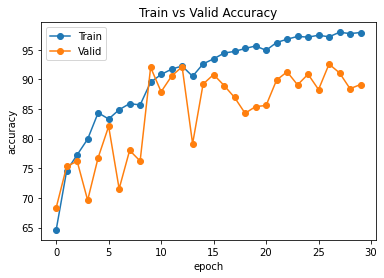

In [16]:
#plot accuracy
plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

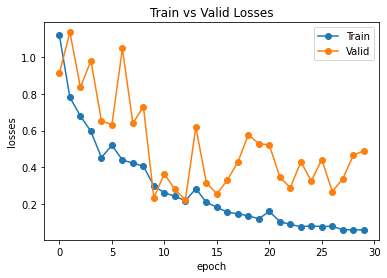

In [17]:
#plot losses

plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [18]:
from sklearn.metrics import confusion_matrix ,classification_report, precision_score, recall_score

# testing
ttloss = []
ttacc = []
ttf1 = []

T_val = []
P_val = []

with torch.no_grad():
    model.eval()
    for (X_val, y_val) in tqdm(test_loader):
        X_val = X_val.float().cuda()
        y_val = y_val.float().cuda()
        #X_val, y_val = X_val.to(device), y_val.to(device)
        #y_val = y_val.type(torch.cuda.LongTensor)
        
        output = model(X_val)
        #print(output.shape)
        
        outputs = torch.max(output, dim=1)[1]
        #print(outputs.shape)
        T_val.extend(y_val.cpu().numpy())
        #print(T_val)
        P_val.extend(outputs.cpu().numpy())
    #print(T_val)
    #print(P_val)
    precision = precision_score(T_val, P_val, average='macro')
    recall = recall_score(T_val, P_val, average='macro')
    res = confusion_matrix(T_val, P_val)
    report = classification_report(T_val, P_val)
    
    print("Precision: ",precision)
    print("Recall: ",recall)

    print('Confusion matrix:\n',res)
    print('Report:\n',report)

100%|████████████████████████████████████████| 169/169 [00:01<00:00, 100.51it/s]

Precision:  0.9036305747751558
Recall:  0.8884833333333333
Confusion matrix:
 [[493   3  13   2   0  18  70   0   1   0]
 [  0 587   6   0   0   6   0   0   1   0]
 [  2   8 569   1   0   2  12   2   4   0]
 [  9   0  28 390  11  15  33   3  11   0]
 [  1   0  55   5 433   0   5   1   0   0]
 [  2  16  13   0   0 353  14   0   0   2]
 [  0   0  92   2   0   3 402   0   1   0]
 [  0   0  44   4  22   0  24 506   0   0]
 [  3   1   4   7   0   3   0   0 482   0]
 [  0   0   1   0   0   0   0   0   1 598]]
Report:
               precision    recall  f1-score   support

         0.0       0.97      0.82      0.89       600
         1.0       0.95      0.98      0.97       600
         2.0       0.69      0.95      0.80       600
         3.0       0.95      0.78      0.86       500
         4.0       0.93      0.87      0.90       500
         5.0       0.88      0.88      0.88       400
         6.0       0.72      0.80      0.76       500
         7.0       0.99      0.84      0.91      

# Running resnet101 model

In [19]:
# Define the ResNet-50 model
model = models.resnet101(pretrained=True)
num_classes = 10
model.fc = nn.Linear(2048, num_classes)

# Modify the first convolution layer to accept 5-channel input
model.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move the model and loss function to the device
model.to(device)
criterion.to(device)

CrossEntropyLoss()

In [20]:
import torchsummary

# Print the model summary
torchsummary.summary(model.to(device), input_size=(4, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]          12,544
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]           4,096
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]          16,384
      BatchNorm2d-12          [-1, 256, 16, 16]             512
           Conv2d-13          [-1, 256, 16, 16]          16,384
      BatchNorm2d-14          [-1, 256,

In [21]:
train_losses = []
train_accu = []

def train(epoch):
    print('Epoch : %d'%epoch)
    
    model.train()
    running_loss=0
    correct=0
    total=0

    for images, labels in tqdm(train_loader):
        
        images = images.float().cuda()
        labels = labels.float().cuda()
        #print(images.size())
        #print(labels.size())
        # Forward pass
        #model = model.cuda()
        outputs = model(images)
        labels1= np.zeros((32,10))
        
        #labels1 = tensor.detach().cpu().numpy()
        for j in range(32):
            i=labels[j]
            i=int(i.item())
            # print(i)
            labels1[j][i]=1
        labels1=torch.from_numpy(labels1)
        #print(labels1.size())
        labels1=labels1.to(device='cuda')
        loss = criterion(outputs, labels1)
        
        
       # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        
    #Replaces pow(2.0) with abs() for L1 regularization
    
#     l2_lambda = 0.001
#     l2_norm = sum(p.pow(2.0).sum()
#                   for p in model.parameters())

#     loss = loss + l2_lambda * l2_norm
    
        
        running_loss += loss.item()
    
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
      
    train_loss=running_loss/len(train_loader)
    accu=100.*correct/total
  
    train_accu.append(accu)
    train_losses.append(train_loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))
    

In [22]:
eval_losses=[]
eval_accu=[]

def test(epoch):
    model.eval()

    running_loss=0
    correct=0
    total=0
    #print(test_loader)
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            
            #images = images.to(device='cuda', dtype=torch.float)
            images = images.float().cuda()
            labels = labels.float().cuda()
            #labels = labels.to(device='cuda', dtype=torch.float)
            
            # Predict classes using the model
            outputs = model(images)
            #print(labels.size())
            t,y=outputs.shape
            # print(t)
            labels1= np.zeros((t,10))
            for j in range(t):
                i=labels[j]
                i=int(i.item())
                labels1[j][i]=1
            labels1=torch.from_numpy(labels1)
            #print(labels1.size())
            labels1=labels1.to(device='cuda')
            #outputs=outputs.tensor()
            loss= criterion(outputs,labels1)
            running_loss+=loss.item()
            
            
           # Compute accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    test_loss=running_loss/len(test_loader)
    accu=100.*correct/total

    eval_losses.append(test_loss)
    eval_accu.append(accu)

    print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 
    

In [23]:
from tqdm import tqdm

In [24]:
import time
epochs = 30

# Start the timer

start_time = time.time()
for epoch in range(1,epochs+1): 
    train(epoch)
    test(epoch)
# End the timer
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time

print('Training time: {:.2f} seconds'.format(training_time))


Epoch : 1


100%|█████████████████████████████████████████| 675/675 [00:41<00:00, 16.37it/s]


Train Loss: 0.857 | Accuracy: 72.264


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 58.46it/s]


Test Loss: 5.887 | Accuracy: 33.981
Epoch : 2


100%|█████████████████████████████████████████| 675/675 [00:41<00:00, 16.34it/s]


Train Loss: 0.619 | Accuracy: 78.500


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 57.36it/s]


Test Loss: 0.505 | Accuracy: 83.185
Epoch : 3


100%|█████████████████████████████████████████| 675/675 [00:41<00:00, 16.32it/s]


Train Loss: 0.405 | Accuracy: 86.153


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 57.03it/s]


Test Loss: 0.381 | Accuracy: 86.981
Epoch : 4


100%|█████████████████████████████████████████| 675/675 [00:41<00:00, 16.27it/s]


Train Loss: 0.333 | Accuracy: 88.537


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 58.44it/s]


Test Loss: 0.436 | Accuracy: 84.926
Epoch : 5


100%|█████████████████████████████████████████| 675/675 [00:41<00:00, 16.13it/s]


Train Loss: 0.275 | Accuracy: 90.296


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 58.47it/s]


Test Loss: 0.627 | Accuracy: 79.222
Epoch : 6


100%|█████████████████████████████████████████| 675/675 [00:41<00:00, 16.30it/s]


Train Loss: 0.317 | Accuracy: 88.968


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 57.46it/s]


Test Loss: 0.423 | Accuracy: 85.167
Epoch : 7


100%|█████████████████████████████████████████| 675/675 [00:41<00:00, 16.24it/s]


Train Loss: 0.220 | Accuracy: 92.245


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 58.43it/s]


Test Loss: 0.701 | Accuracy: 79.222
Epoch : 8


100%|█████████████████████████████████████████| 675/675 [00:41<00:00, 16.32it/s]


Train Loss: 0.198 | Accuracy: 93.083


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 56.91it/s]


Test Loss: 0.266 | Accuracy: 91.056
Epoch : 9


100%|█████████████████████████████████████████| 675/675 [00:41<00:00, 16.31it/s]


Train Loss: 0.172 | Accuracy: 93.875


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 57.56it/s]


Test Loss: 0.205 | Accuracy: 93.222
Epoch : 10


100%|█████████████████████████████████████████| 675/675 [00:41<00:00, 16.26it/s]


Train Loss: 0.171 | Accuracy: 94.347


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 58.24it/s]


Test Loss: 0.267 | Accuracy: 91.204
Epoch : 11


100%|█████████████████████████████████████████| 675/675 [00:41<00:00, 16.22it/s]


Train Loss: 0.152 | Accuracy: 94.852


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 58.59it/s]


Test Loss: 0.341 | Accuracy: 89.833
Epoch : 12


100%|█████████████████████████████████████████| 675/675 [00:41<00:00, 16.27it/s]


Train Loss: 0.121 | Accuracy: 95.681


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 57.67it/s]


Test Loss: 0.971 | Accuracy: 76.630
Epoch : 13


100%|█████████████████████████████████████████| 675/675 [00:41<00:00, 16.21it/s]


Train Loss: 0.121 | Accuracy: 95.856


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 58.01it/s]


Test Loss: 0.268 | Accuracy: 92.130
Epoch : 14


100%|█████████████████████████████████████████| 675/675 [00:41<00:00, 16.44it/s]


Train Loss: 0.121 | Accuracy: 95.875


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 58.28it/s]


Test Loss: 0.342 | Accuracy: 88.074
Epoch : 15


100%|█████████████████████████████████████████| 675/675 [00:40<00:00, 16.51it/s]


Train Loss: 0.086 | Accuracy: 97.097


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 57.70it/s]


Test Loss: 0.288 | Accuracy: 92.148
Epoch : 16


100%|█████████████████████████████████████████| 675/675 [00:41<00:00, 16.43it/s]


Train Loss: 0.086 | Accuracy: 97.014


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 57.46it/s]


Test Loss: 0.924 | Accuracy: 77.370
Epoch : 17


100%|█████████████████████████████████████████| 675/675 [00:41<00:00, 16.39it/s]


Train Loss: 0.082 | Accuracy: 97.194


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 54.40it/s]


Test Loss: 0.211 | Accuracy: 93.667
Epoch : 18


100%|█████████████████████████████████████████| 675/675 [00:40<00:00, 16.51it/s]


Train Loss: 0.101 | Accuracy: 96.736


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 57.71it/s]


Test Loss: 0.368 | Accuracy: 90.259
Epoch : 19


100%|█████████████████████████████████████████| 675/675 [00:41<00:00, 16.43it/s]


Train Loss: 0.074 | Accuracy: 97.542


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 58.29it/s]


Test Loss: 0.267 | Accuracy: 92.870
Epoch : 20


100%|█████████████████████████████████████████| 675/675 [00:40<00:00, 16.52it/s]


Train Loss: 0.068 | Accuracy: 97.657


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 57.58it/s]


Test Loss: 0.227 | Accuracy: 93.444
Epoch : 21


100%|█████████████████████████████████████████| 675/675 [00:40<00:00, 16.48it/s]


Train Loss: 0.058 | Accuracy: 97.940


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 57.76it/s]


Test Loss: 0.398 | Accuracy: 88.796
Epoch : 22


100%|█████████████████████████████████████████| 675/675 [00:41<00:00, 16.39it/s]


Train Loss: 0.074 | Accuracy: 97.449


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 57.99it/s]


Test Loss: 0.368 | Accuracy: 89.870
Epoch : 23


100%|█████████████████████████████████████████| 675/675 [00:41<00:00, 16.40it/s]


Train Loss: 0.050 | Accuracy: 98.259


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 57.94it/s]


Test Loss: 0.219 | Accuracy: 93.778
Epoch : 24


100%|█████████████████████████████████████████| 675/675 [00:41<00:00, 16.43it/s]


Train Loss: 0.061 | Accuracy: 97.866


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 57.59it/s]


Test Loss: 0.394 | Accuracy: 91.000
Epoch : 25


100%|█████████████████████████████████████████| 675/675 [00:40<00:00, 16.47it/s]


Train Loss: 0.040 | Accuracy: 98.671


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 58.24it/s]


Test Loss: 0.332 | Accuracy: 91.019
Epoch : 26


100%|█████████████████████████████████████████| 675/675 [00:40<00:00, 16.48it/s]


Train Loss: 0.063 | Accuracy: 97.852


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 58.24it/s]


Test Loss: 0.326 | Accuracy: 91.481
Epoch : 27


100%|█████████████████████████████████████████| 675/675 [00:40<00:00, 16.48it/s]


Train Loss: 0.037 | Accuracy: 98.722


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 57.26it/s]


Test Loss: 0.393 | Accuracy: 90.444
Epoch : 28


100%|█████████████████████████████████████████| 675/675 [00:41<00:00, 16.45it/s]


Train Loss: 0.041 | Accuracy: 98.699


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 58.52it/s]


Test Loss: 0.498 | Accuracy: 87.667
Epoch : 29


100%|█████████████████████████████████████████| 675/675 [00:41<00:00, 16.33it/s]


Train Loss: 0.037 | Accuracy: 98.782


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 57.62it/s]


Test Loss: 0.333 | Accuracy: 91.889
Epoch : 30


100%|█████████████████████████████████████████| 675/675 [00:40<00:00, 16.48it/s]


Train Loss: 0.041 | Accuracy: 98.620


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 58.25it/s]

Test Loss: 0.324 | Accuracy: 92.037
Training time: 1324.77 seconds


In [25]:
import matplotlib.pyplot as plt


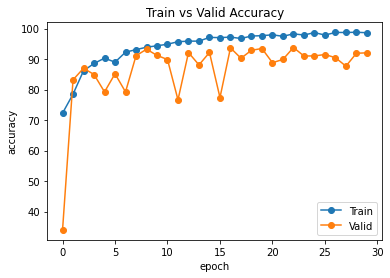

In [26]:
#plot accuracy
plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

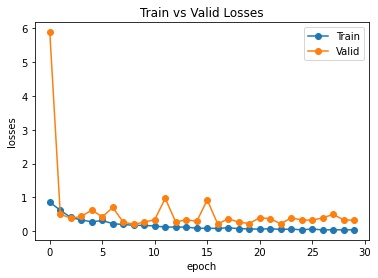

In [27]:
#plot losses

plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [28]:
from sklearn.metrics import confusion_matrix ,classification_report, precision_score, recall_score

# testing
ttloss = []
ttacc = []
ttf1 = []

T_val = []
P_val = []

with torch.no_grad():
    model.eval()
    for (X_val, y_val) in tqdm(test_loader):
        X_val = X_val.float().cuda()
        y_val = y_val.float().cuda()
        #X_val, y_val = X_val.to(device), y_val.to(device)
        #y_val = y_val.type(torch.cuda.LongTensor)
        
        output = model(X_val)
        #print(output.shape)
        
        outputs = torch.max(output, dim=1)[1]
        #print(outputs.shape)
        T_val.extend(y_val.cpu().numpy())
        #print(T_val)
        P_val.extend(outputs.cpu().numpy())
    #print(T_val)
    #print(P_val)
    precision = precision_score(T_val, P_val, average='macro')
    recall = recall_score(T_val, P_val, average='macro')
    res = confusion_matrix(T_val, P_val)
    report = classification_report(T_val, P_val)
    
    print("Precision: ",precision)
    print("Recall: ",recall)

    print('Confusion matrix:\n',res)
    print('Report:\n',report)

100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 60.00it/s]

Precision:  0.9205240684699113
Recall:  0.9181333333333335
Confusion matrix:
 [[533   3   7  20   0  13  24   0   0   0]
 [  3 565   8   7   0  16   0   0   1   0]
 [  7   5 538   6   5   1  25   9   3   1]
 [  5   0   8 463   6   4   3   8   3   0]
 [  0   0   0  14 454   0   0  32   0   0]
 [  3   2  13   1   0 366  15   0   0   0]
 [  8   0  58  19   6   1 398  10   0   0]
 [  0   1   2   6   1   0   1 589   0   0]
 [  7   1   2  15   1   8   0   1 464   1]
 [  0   0   0   0   0   0   0   0   0 600]]
Report:
               precision    recall  f1-score   support

         0.0       0.94      0.89      0.91       600
         1.0       0.98      0.94      0.96       600
         2.0       0.85      0.90      0.87       600
         3.0       0.84      0.93      0.88       500
         4.0       0.96      0.91      0.93       500
         5.0       0.89      0.92      0.90       400
         6.0       0.85      0.80      0.82       500
         7.0       0.91      0.98      0.94      

# Running Resnet 152 model

In [49]:
# Define the ResNet-152 model
model = models.resnet152(pretrained=False)
num_classes = 10
model.fc = nn.Linear(2048, num_classes)

# Modify the first convolution layer to accept 5-channel input
model.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move the model and loss function to the device
model.to(device)
criterion.to(device)

CrossEntropyLoss()

In [50]:
import torchsummary

# Print the model summary
torchsummary.summary(model.to(device), input_size=(4, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]          12,544
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]           4,096
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]          16,384
      BatchNorm2d-12          [-1, 256, 16, 16]             512
           Conv2d-13          [-1, 256, 16, 16]          16,384
      BatchNorm2d-14          [-1, 256,

In [51]:
train_losses = []
train_accu = []

def train(epoch):
    print('Epoch : %d'%epoch)
    
    model.train()
    running_loss=0
    correct=0
    total=0

    for images, labels in tqdm(train_loader):
        
        images = images.float().cuda()
        labels = labels.float().cuda()
        #print(images.size())
        #print(labels.size())
        # Forward pass
        #model = model.cuda()
        outputs = model(images)
        labels1= np.zeros((32,10))
        
        #labels1 = tensor.detach().cpu().numpy()
        for j in range(32):
            i=labels[j]
            i=int(i.item())
            # print(i)
            labels1[j][i]=1
        labels1=torch.from_numpy(labels1)
        #print(labels1.size())
        labels1=labels1.to(device='cuda')
        loss = criterion(outputs, labels1)
        
        
       # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        
    #Replaces pow(2.0) with abs() for L1 regularization
    
#     l2_lambda = 0.001
#     l2_norm = sum(p.pow(2.0).sum()
#                   for p in model.parameters())

#     loss = loss + l2_lambda * l2_norm
    
        
        running_loss += loss.item()
    
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
      
    train_loss=running_loss/len(train_loader)
    accu=100.*correct/total
  
    train_accu.append(accu)
    train_losses.append(train_loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))
    

In [52]:
eval_losses=[]
eval_accu=[]

def test(epoch):
    model.eval()

    running_loss=0
    correct=0
    total=0
    #print(test_loader)
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            
            #images = images.to(device='cuda', dtype=torch.float)
            images = images.float().cuda()
            labels = labels.float().cuda()
            #labels = labels.to(device='cuda', dtype=torch.float)
            
            # Predict classes using the model
            outputs = model(images)
            #print(labels.size())
            t,y=outputs.shape
            # print(t)
            labels1= np.zeros((t,10))
            for j in range(t):
                i=labels[j]
                i=int(i.item())
                labels1[j][i]=1
            labels1=torch.from_numpy(labels1)
            #print(labels1.size())
            labels1=labels1.to(device='cuda')
            #outputs=outputs.tensor()
            loss= criterion(outputs,labels1)
            running_loss+=loss.item()
            
            
           # Compute accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    test_loss=running_loss/len(test_loader)
    accu=100.*correct/total

    eval_losses.append(test_loss)
    eval_accu.append(accu)

    print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 
    

In [53]:
from tqdm import tqdm

In [54]:
import time
epochs = 35

# Start the timer

start_time = time.time()
for epoch in range(1,epochs+1): 
    train(epoch)
    test(epoch)
# End the timer
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time

print('Training time: {:.2f} seconds'.format(training_time))


Epoch : 1


100%|█████████████████████████████████████████| 675/675 [00:57<00:00, 11.79it/s]


Train Loss: 1.275 | Accuracy: 57.102


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 42.31it/s]


Test Loss: 2.644 | Accuracy: 48.167
Epoch : 2


100%|█████████████████████████████████████████| 675/675 [00:57<00:00, 11.76it/s]


Train Loss: 1.115 | Accuracy: 65.444


100%|█████████████████████████████████████████| 169/169 [00:04<00:00, 42.02it/s]


Test Loss: 4.393 | Accuracy: 65.815
Epoch : 3


100%|█████████████████████████████████████████| 675/675 [00:57<00:00, 11.69it/s]


Train Loss: 0.926 | Accuracy: 69.042


100%|█████████████████████████████████████████| 169/169 [00:04<00:00, 41.52it/s]


Test Loss: 0.998 | Accuracy: 68.167
Epoch : 4


100%|█████████████████████████████████████████| 675/675 [00:57<00:00, 11.73it/s]


Train Loss: 0.773 | Accuracy: 74.616


100%|█████████████████████████████████████████| 169/169 [00:04<00:00, 42.05it/s]


Test Loss: 6.066 | Accuracy: 59.148
Epoch : 5


100%|█████████████████████████████████████████| 675/675 [00:57<00:00, 11.69it/s]


Train Loss: 0.738 | Accuracy: 75.005


100%|█████████████████████████████████████████| 169/169 [00:04<00:00, 38.86it/s]


Test Loss: 1.624 | Accuracy: 67.407
Epoch : 6


100%|█████████████████████████████████████████| 675/675 [00:57<00:00, 11.84it/s]


Train Loss: 0.740 | Accuracy: 75.125


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 42.91it/s]


Test Loss: 91.802 | Accuracy: 59.463
Epoch : 7


100%|█████████████████████████████████████████| 675/675 [00:56<00:00, 11.89it/s]


Train Loss: 0.664 | Accuracy: 77.088


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 42.85it/s]


Test Loss: 0.736 | Accuracy: 81.389
Epoch : 8


100%|█████████████████████████████████████████| 675/675 [00:56<00:00, 11.87it/s]


Train Loss: 0.489 | Accuracy: 83.190


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 42.94it/s]


Test Loss: 0.526 | Accuracy: 83.944
Epoch : 9


100%|█████████████████████████████████████████| 675/675 [00:56<00:00, 11.87it/s]


Train Loss: 0.466 | Accuracy: 84.245


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 42.87it/s]


Test Loss: 3.095 | Accuracy: 63.667
Epoch : 10


100%|█████████████████████████████████████████| 675/675 [00:56<00:00, 11.90it/s]


Train Loss: 0.548 | Accuracy: 81.106


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 42.84it/s]


Test Loss: 0.414 | Accuracy: 85.185
Epoch : 11


100%|█████████████████████████████████████████| 675/675 [00:56<00:00, 11.85it/s]


Train Loss: 0.447 | Accuracy: 84.667


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 42.85it/s]


Test Loss: 0.517 | Accuracy: 82.352
Epoch : 12


100%|█████████████████████████████████████████| 675/675 [00:56<00:00, 11.89it/s]


Train Loss: 0.389 | Accuracy: 86.472


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 42.91it/s]


Test Loss: 0.570 | Accuracy: 85.241
Epoch : 13


100%|█████████████████████████████████████████| 675/675 [00:56<00:00, 11.86it/s]


Train Loss: 0.320 | Accuracy: 88.843


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 42.90it/s]


Test Loss: 5.027 | Accuracy: 69.648
Epoch : 14


100%|█████████████████████████████████████████| 675/675 [00:56<00:00, 11.85it/s]


Train Loss: 0.286 | Accuracy: 89.972


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 42.85it/s]


Test Loss: 0.405 | Accuracy: 85.463
Epoch : 15


100%|█████████████████████████████████████████| 675/675 [00:57<00:00, 11.75it/s]


Train Loss: 0.275 | Accuracy: 90.398


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 42.91it/s]


Test Loss: 0.730 | Accuracy: 78.148
Epoch : 16


100%|█████████████████████████████████████████| 675/675 [00:56<00:00, 11.85it/s]


Train Loss: 0.238 | Accuracy: 91.653


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 42.83it/s]


Test Loss: 0.346 | Accuracy: 88.093
Epoch : 17


100%|█████████████████████████████████████████| 675/675 [00:56<00:00, 11.88it/s]


Train Loss: 0.232 | Accuracy: 91.685


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 42.72it/s]


Test Loss: 1.603 | Accuracy: 65.296
Epoch : 18


100%|█████████████████████████████████████████| 675/675 [00:57<00:00, 11.78it/s]


Train Loss: 0.233 | Accuracy: 91.824


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 42.61it/s]


Test Loss: 0.522 | Accuracy: 89.500
Epoch : 19


100%|█████████████████████████████████████████| 675/675 [00:56<00:00, 11.87it/s]


Train Loss: 0.214 | Accuracy: 92.606


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 42.61it/s]


Test Loss: 0.484 | Accuracy: 87.222
Epoch : 20


100%|█████████████████████████████████████████| 675/675 [00:56<00:00, 11.86it/s]


Train Loss: 0.177 | Accuracy: 93.699


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 42.65it/s]


Test Loss: 0.261 | Accuracy: 91.259
Epoch : 21


100%|█████████████████████████████████████████| 675/675 [00:57<00:00, 11.82it/s]


Train Loss: 0.237 | Accuracy: 91.722


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 42.68it/s]


Test Loss: 0.318 | Accuracy: 89.796
Epoch : 22


100%|█████████████████████████████████████████| 675/675 [00:57<00:00, 11.80it/s]


Train Loss: 0.145 | Accuracy: 94.838


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 42.79it/s]


Test Loss: 0.411 | Accuracy: 86.481
Epoch : 23


100%|█████████████████████████████████████████| 675/675 [00:57<00:00, 11.81it/s]


Train Loss: 0.167 | Accuracy: 94.185


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 42.70it/s]


Test Loss: 1.650 | Accuracy: 87.222
Epoch : 24


100%|█████████████████████████████████████████| 675/675 [00:56<00:00, 11.85it/s]


Train Loss: 0.123 | Accuracy: 95.579


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 42.72it/s]


Test Loss: 1.958 | Accuracy: 69.130
Epoch : 25


100%|█████████████████████████████████████████| 675/675 [00:57<00:00, 11.83it/s]


Train Loss: 0.113 | Accuracy: 96.250


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 42.68it/s]


Test Loss: 0.506 | Accuracy: 87.481
Epoch : 26


100%|█████████████████████████████████████████| 675/675 [00:57<00:00, 11.82it/s]


Train Loss: 0.105 | Accuracy: 96.264


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 42.78it/s]


Test Loss: 0.567 | Accuracy: 85.222
Epoch : 27


100%|█████████████████████████████████████████| 675/675 [00:58<00:00, 11.61it/s]


Train Loss: 0.086 | Accuracy: 96.977


100%|█████████████████████████████████████████| 169/169 [00:04<00:00, 41.57it/s]


Test Loss: 0.415 | Accuracy: 88.352
Epoch : 28


100%|█████████████████████████████████████████| 675/675 [00:57<00:00, 11.78it/s]


Train Loss: 0.098 | Accuracy: 96.454


100%|█████████████████████████████████████████| 169/169 [00:04<00:00, 40.52it/s]


Test Loss: 0.298 | Accuracy: 91.833
Epoch : 29


100%|█████████████████████████████████████████| 675/675 [00:57<00:00, 11.78it/s]


Train Loss: 0.130 | Accuracy: 95.870


100%|█████████████████████████████████████████| 169/169 [00:04<00:00, 41.62it/s]


Test Loss: 0.712 | Accuracy: 86.574
Epoch : 30


100%|█████████████████████████████████████████| 675/675 [00:57<00:00, 11.80it/s]


Train Loss: 0.076 | Accuracy: 97.329


100%|█████████████████████████████████████████| 169/169 [00:04<00:00, 41.64it/s]


Test Loss: 1.080 | Accuracy: 90.444
Epoch : 31


100%|█████████████████████████████████████████| 675/675 [00:57<00:00, 11.74it/s]


Train Loss: 0.072 | Accuracy: 97.431


100%|█████████████████████████████████████████| 169/169 [00:04<00:00, 41.70it/s]


Test Loss: 0.896 | Accuracy: 86.389
Epoch : 32


100%|█████████████████████████████████████████| 675/675 [00:57<00:00, 11.79it/s]


Train Loss: 0.076 | Accuracy: 97.583


100%|█████████████████████████████████████████| 169/169 [00:04<00:00, 41.79it/s]


Test Loss: 0.685 | Accuracy: 90.537
Epoch : 33


100%|█████████████████████████████████████████| 675/675 [00:57<00:00, 11.73it/s]


Train Loss: 0.098 | Accuracy: 96.792


100%|█████████████████████████████████████████| 169/169 [00:04<00:00, 41.17it/s]


Test Loss: 2.382 | Accuracy: 89.019
Epoch : 34


100%|█████████████████████████████████████████| 675/675 [00:57<00:00, 11.77it/s]


Train Loss: 0.059 | Accuracy: 97.787


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 42.71it/s]


Test Loss: 1.374 | Accuracy: 90.889
Epoch : 35


100%|█████████████████████████████████████████| 675/675 [00:57<00:00, 11.80it/s]


Train Loss: 0.052 | Accuracy: 98.241


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 42.70it/s]

Test Loss: 0.435 | Accuracy: 89.333
Training time: 2141.19 seconds


In [55]:
import matplotlib.pyplot as plt


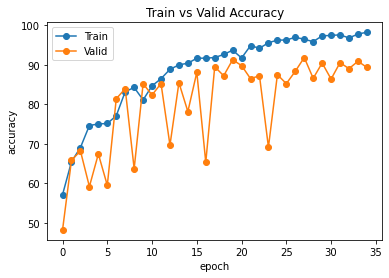

In [56]:
#plot accuracy
plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

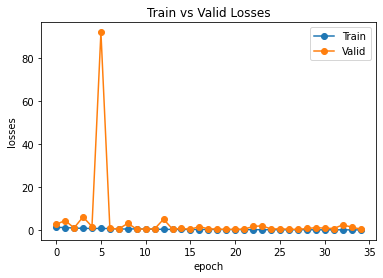

In [57]:
#plot losses

plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [58]:
from sklearn.metrics import confusion_matrix ,classification_report, precision_score, recall_score

# testing
ttloss = []
ttacc = []
ttf1 = []

T_val = []
P_val = []

with torch.no_grad():
    model.eval()
    for (X_val, y_val) in tqdm(test_loader):
        X_val = X_val.float().cuda()
        y_val = y_val.float().cuda()
        #X_val, y_val = X_val.to(device), y_val.to(device)
        #y_val = y_val.type(torch.cuda.LongTensor)
        
        output = model(X_val)
        #print(output.shape)
        
        outputs = torch.max(output, dim=1)[1]
        #print(outputs.shape)
        T_val.extend(y_val.cpu().numpy())
        #print(T_val)
        P_val.extend(outputs.cpu().numpy())
    #print(T_val)
    #print(P_val)
    precision = precision_score(T_val, P_val, average='macro')
    recall = recall_score(T_val, P_val, average='macro')
    res = confusion_matrix(T_val, P_val)
    report = classification_report(T_val, P_val)
    
    print("Precision: ",precision)
    print("Recall: ",recall)

    print('Confusion matrix:\n',res)
    print('Report:\n',report)

100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 43.36it/s]

Precision:  0.9054981808715512
Recall:  0.8895166666666666
Confusion matrix:
 [[525   3  32   5   0   7  28   0   0   0]
 [  1 573  13   0   0  12   0   0   1   0]
 [  0   7 578   2   2   2   6   0   3   0]
 [  9   0  11 427  32   6   8   1   6   0]
 [  0   0   3   5 488   0   1   2   1   0]
 [ 11  11  22   3   0 341  12   0   0   0]
 [ 18   0 143  11   2   4 321   0   1   0]
 [  0   1  60   4  27   0  11 497   0   0]
 [  4   1   3   9   2   4   0   0 477   0]
 [  0   0   2   0   0   0   0   0   1 597]]
Report:
               precision    recall  f1-score   support

         0.0       0.92      0.88      0.90       600
         1.0       0.96      0.95      0.96       600
         2.0       0.67      0.96      0.79       600
         3.0       0.92      0.85      0.88       500
         4.0       0.88      0.98      0.93       500
         5.0       0.91      0.85      0.88       400
         6.0       0.83      0.64      0.72       500
         7.0       0.99      0.83      0.90      